## 測試Esun data 使用不同Classifier的預測結果

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


random_state = 0

# 測試10個字

In [2]:
img_list = []
data_path = '/home/yehchehsin/Desktop/ESunBank_Competition/train_image/'
num_class = 10
#label dir 
folder_list = os.listdir(data_path)
num_class = 10
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            

## Load Image

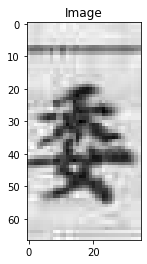

In [3]:
plt.title('Image')
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

In [4]:
total_img = []
total_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((50,50),Image.BILINEAR)
    total_label.append(label)
    total_img.append(np.array(img).reshape(-1))
total_img = np.array(total_img)
total_label = np.array(total_label)
print("Total label shape:",total_label.shape)
print("Total image shape:",total_img.shape)

Total label shape: (740,)
Total image shape: (740, 2500)


# Split train and test set

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.2,random_state=0)

# PCA explain ratio

Text(0, 0.5, 'cumulative explained variance')

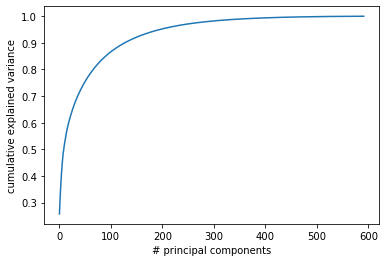

In [6]:
# 多少components 就可以代表0.95的資料
n_compons_rate = 0.95
pca = PCA()
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

dim reduction one image

principle components shape: (6, 2500)


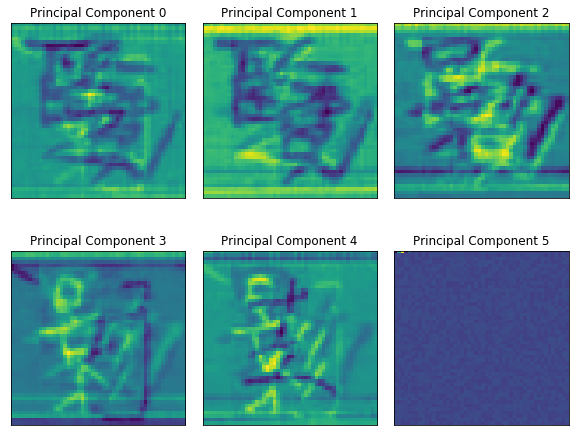

In [7]:
from sklearn.preprocessing import minmax_scale
pca = PCA()
trans_img = pca.fit_transform(X_train[:6])

scaled_comps = minmax_scale(pca.components_,axis=1)
print("principle components shape:",pca.components_.shape)
fig,axes = plt.subplots(2,3,figsize=(10,8),
                        subplot_kw = {"xticks":[],'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.set_title('Principal Component '+str(i))
    ax.imshow(c.reshape(50,50))


# predict function

In [8]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

In [9]:
## PCA

In [10]:
pca = PCA(0.8,random_state=random_state)
pipe = make_pipeline(StandardScaler(),pca)
pca.fit(X_train)

transformed_train = pca.transform(X_train)
transformed_test = pca.transform(X_test)

print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)


-----PCA dimension reduction----
transformed train images.shape: (592, 67)
transformed test  images.shape: (148, 67)


# SVM 

In [11]:
from sklearn import svm

# PCA components數 影響 SVM accuracy

In [12]:
for i in range(90,0,-10):
    pca = PCA(i/100,random_state=random_state)
    pipe = make_pipeline(StandardScaler(),pca)
    transformed_images = pca.fit_transform(X_train)
#     print("transformed_images.shape:",transformed_images.shape)
    transform_test = pca.transform(X_test)
    clf = svm.SVC()
    clf.fit(transformed_images,Y_train)
    res = clf.predict(transform_test)
    acc = predict_accuracy(res,Y_test)
    print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))

128 components accuracy:45.27%
67 components accuracy:50.68%
37 components accuracy:50.00%
19 components accuracy:54.05%
10 components accuracy:41.89%
5 components accuracy:27.03%
2 components accuracy:17.57%
1 components accuracy:14.86%
1 components accuracy:14.86%


# Perceptron

In [13]:
from sklearn.linear_model import Perceptron

In [14]:
print(transformed_train.shape)
print(transformed_test.shape)

(592, 67)
(148, 67)


In [15]:
clf = make_pipeline(StandardScaler(),Perceptron(tol=1e-5,random_state=random_state))
clf.fit(transformed_train,Y_train)
clf.score(transformed_train,Y_train)
clf.score(transformed_test,Y_test)

0.40540540540540543

# MLP

In [16]:
from  sklearn.neural_network import MLPClassifier
max_iter = 1000
clf = make_pipeline(StandardScaler(),MLPClassifier(max_iter=max_iter,random_state=random_state))
clf.fit(transformed_train,Y_train)
res = clf.predict(transformed_test)
print("{} iter accuracy:{}".format(max_iter,predict_accuracy(res,Y_test)))


1000 iter accuracy:0.5067567567567568


In [18]:
max_iter = 5000
for i in range(90,40,-10):
    pca = PCA(i/100,random_state=random_state)
    pipe = make_pipeline(StandardScaler(),pca)
    transform_images = pca.fit_transform(X_train)
    transform_test = pca.transform(X_test)
    clf = make_pipeline(StandardScaler(),MLPClassifier(max_iter=max_iter,random_state=random_state))
    clf.fit(transform_images,Y_train)
    res = clf.predict(transform_test)
    acc = predict_accuracy(res,Y_test)
    print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))

128 components accuracy:41.89%
67 components accuracy:50.68%
37 components accuracy:48.65%
19 components accuracy:53.38%
10 components accuracy:45.27%
